<a href="https://colab.research.google.com/github/adijams01/Sneakers_CNN/blob/main/Sneakers_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Becoming one with data

In [5]:
import zipfile

# Unzip the downloaded file from github or kaggle "https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged?resource=download"
zip_ref = zipfile.ZipFile("Sneakers_CNN.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [6]:
import os

# Walk through  directory and list number of files
print("TRAIN---")
for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("TEST---")
for dirpath, dirnames, filenames in os.walk("test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

TRAIN---
There are 3 directories and 0 images in 'train'.
There are 0 directories and 237 images in 'train/nike'.
There are 0 directories and 237 images in 'train/converse'.
There are 0 directories and 237 images in 'train/adidas'.
TEST---
There are 3 directories and 0 images in 'test'.
There are 0 directories and 38 images in 'test/nike'.
There are 0 directories and 38 images in 'test/converse'.
There are 0 directories and 38 images in 'test/adidas'.


## Preprocessing Data

In [7]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/train"
test_dir = "/content/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 711 images belonging to 3 classes.
Testing images:
Found 114 images belonging to 3 classes.


## Setting Callbacks

In [8]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback
     

In [14]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Creating models using Tensorflow Hub

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Models used :
* Resnet V2 50
* EfficientNet B0 (version 1)
* EfficientNet B0 (version 2)
* MobileNet V2

In [24]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# New: EfficientNetB0 feature vector (version 2)
efficientnet_2_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

# MobileNet V2 feature vector
mobilenet_url="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [11]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

#### Resnet

In [12]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230228-152728
Epoch 1/5
23/23 [==============================] - 19s 219ms/step - loss: 0.9993 - accuracy: 0.5091 - val_loss: 0.8047 - val_accuracy: 0.6491
Epoch 2/5
23/23 [==============================] - 2s 106ms/step - loss: 0.6376 - accuracy: 0.7356 - val_loss: 0.6863 - val_accuracy: 0.7018
Epoch 3/5
23/23 [==============================] - 3s 108ms/step - loss: 0.5183 - accuracy: 0.8115 - val_loss: 0.6317 - val_accuracy: 0.7018
Epoch 4/5
23/23 [==============================] - 2s 105ms/step - loss: 0.4382 - accuracy: 0.8664 - val_loss: 0.6110 - val_accuracy: 0.7368
Epoch 5/5
23/23 [==============================] - 3s 131ms/step - loss: 0.3842 - accuracy: 0.8790 - val_loss: 0.5968 - val_accuracy: 0.7456


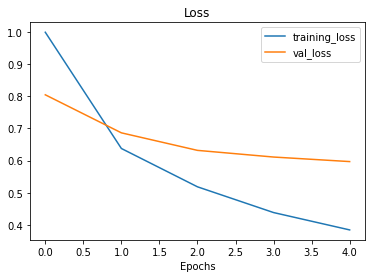

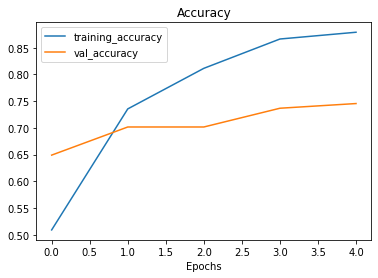

In [15]:
plot_loss_curves(resnet_history)

In [16]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 6147      
                                                                 
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
_________________________________________________________________


#### EfficientNet (Version 1)

In [17]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230228-153030
Epoch 1/5
23/23 [==============================] - 16s 229ms/step - loss: 1.0455 - accuracy: 0.4613 - val_loss: 0.8730 - val_accuracy: 0.6579
Epoch 2/5
23/23 [==============================] - 2s 96ms/step - loss: 0.7864 - accuracy: 0.7342 - val_loss: 0.7143 - val_accuracy: 0.7807
Epoch 3/5
23/23 [==============================] - 3s 126ms/step - loss: 0.6500 - accuracy: 0.8031 - val_loss: 0.6404 - val_accuracy: 0.7895
Epoch 4/5
23/23 [==============================] - 2s 96ms/step - loss: 0.5666 - accuracy: 0.8397 - val_loss: 0.5915 - val_accuracy: 0.7807
Epoch 5/5
23/23 [==============================] - 2s 94ms/step - loss: 0.5133 - accuracy: 0.8579 - val_loss: 0.5555 - val_accuracy: 0.7982


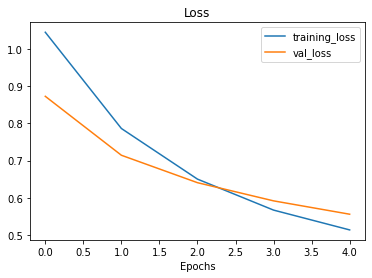

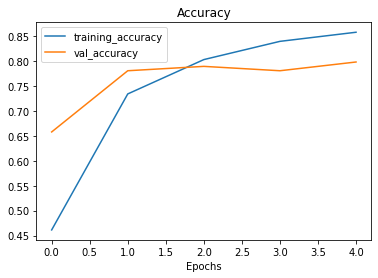

In [18]:
plot_loss_curves(efficientnet_history)

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


#### EfficientNet (Version 2)

In [20]:
# Create model
efficientnet_2_model = create_model(model_url=efficientnet_2_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_2_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_2_history = efficientnet_2_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnet_2_B0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnet_2_B0/20230228-153311
Epoch 1/5
23/23 [==============================] - 11s 189ms/step - loss: 0.9831 - accuracy: 0.5331 - val_loss: 0.8473 - val_accuracy: 0.6754
Epoch 2/5
23/23 [==============================] - 2s 91ms/step - loss: 0.7809 - accuracy: 0.6835 - val_loss: 0.7389 - val_accuracy: 0.7368
Epoch 3/5
23/23 [==============================] - 2s 104ms/step - loss: 0.6627 - accuracy: 0.7834 - val_loss: 0.6592 - val_accuracy: 0.7895
Epoch 4/5
23/23 [==============================] - 2s 98ms/step - loss: 0.5887 - accuracy: 0.8298 - val_loss: 0.6130 - val_accuracy: 0.7807
Epoch 5/5
23/23 [==============================] - 3s 107ms/step - loss: 0.5372 - accuracy: 0.8467 - val_loss: 0.5777 - val_accuracy: 0.8246


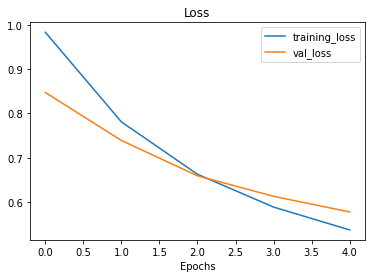

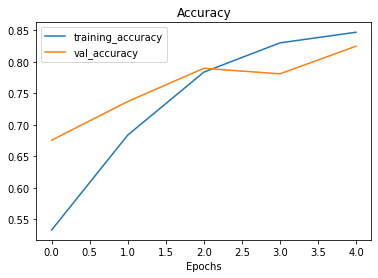

In [21]:
plot_loss_curves(efficientnet_2_history)

#### MobileNet

In [25]:
# Create model
mobilenet_model = create_model(model_url=mobilenet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
mobilenet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
mobilenet_history = mobilenet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="mobilenetB0")])

Saving TensorBoard log files to: tensorflow_hub/mobilenetB0/20230228-153927
Epoch 1/5
23/23 [==============================] - 7s 124ms/step - loss: 1.0286 - accuracy: 0.4852 - val_loss: 0.8243 - val_accuracy: 0.6228
Epoch 2/5
23/23 [==============================] - 2s 89ms/step - loss: 0.7589 - accuracy: 0.6582 - val_loss: 0.7156 - val_accuracy: 0.7105
Epoch 3/5
23/23 [==============================] - 2s 89ms/step - loss: 0.6173 - accuracy: 0.7595 - val_loss: 0.6525 - val_accuracy: 0.7632
Epoch 4/5
23/23 [==============================] - 2s 106ms/step - loss: 0.5338 - accuracy: 0.8031 - val_loss: 0.6292 - val_accuracy: 0.7018
Epoch 5/5
23/23 [==============================] - 4s 163ms/step - loss: 0.4783 - accuracy: 0.8340 - val_loss: 0.6115 - val_accuracy: 0.7368


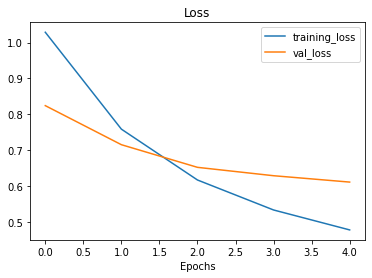

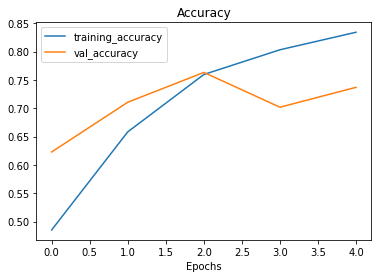

In [26]:
plot_loss_curves(mobilenet_history)

In [27]:
mobilenet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## Comparing models on Tensorboard
Don't put any private data here because it is available in public

In [31]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Sneakers_CNN" \
  --description "Comparing different models for Sneaker's Dataset" \
  --one_shot
     

2023-02-28 15:46:43.598843: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-28 15:46:43.598940: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-28 15:46:43.598957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/1sEjm0kgR1CvMxeAGPN4SA/

[2023-02-28T15:46:45] Started scanning logdir.
[2023-02-

In [50]:
# Link to TensorBoard
# https://tensorboard.dev/experiment/WtnFkayNRLuV3WOnb1CRyQ/#scalars&runSelectionState=eyJlZmZpY2llbnRuZXRCMC8yMDIzMDIyOC0xNTMwMzAvdHJhaW4iOnRydWUsImVmZmljaWVudG5ldEIwLzIwMjMwMjI4LTE1MzAzMC92YWxpZGF0aW9uIjpmYWxzZSwiZWZmaWNpZW50bmV0XzJfQjAvMjAyMzAyMjgtMTUzMzExL3RyYWluIjpmYWxzZSwiZWZmaWNpZW50bmV0XzJfQjAvMjAyMzAyMjgtMTUzMzExL3ZhbGlkYXRpb24iOmZhbHNlLCJtb2JpbGVuZXRCMC8yMDIzMDIyOC0xNTM5MjcvdHJhaW4iOmZhbHNlLCJtb2JpbGVuZXRCMC8yMDIzMDIyOC0xNTM5MjcvdmFsaWRhdGlvbiI6ZmFsc2UsInJlc25ldDUwVjIvMjAyMzAyMjgtMTUyNzI4L3RyYWluIjpmYWxzZSwicmVzbmV0NTBWMi8yMDIzMDIyOC0xNTI3MjgvdmFsaWRhdGlvbiI6ZmFsc2V9&_smoothingWeight=0.871

# Delete an experiment
# !tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]
# Check to see if experiments still exist
# !tensorboard dev list

## Predictions

In [34]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [35]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [37]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['adidas' 'converse' 'nike']


1/1 [==============================] - 0s 49ms/step


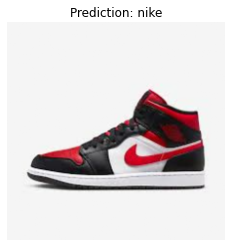

In [45]:
# Make a prediction using efficienet_2_model
pred_and_plot(model=efficientnet_2_model, 
              filename="nike_example.jpeg", 
              class_names=class_names)

1/1 [==============================] - 0s 29ms/step


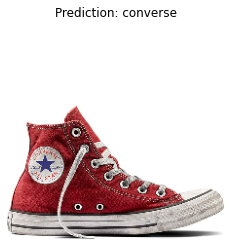

In [46]:
# Make a prediction using model_1
pred_and_plot(model=efficientnet_2_model, 
              filename="converse_example.jpg", 
              class_names=class_names)

1/1 [==============================] - 0s 36ms/step


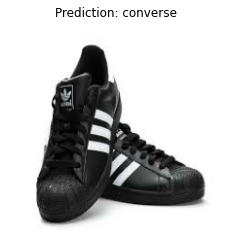

In [49]:
# Make a prediction using model_1
pred_and_plot(model=efficientnet_2_model, 
              filename="adidas_example.jpeg", 
              class_names=class_names)

In [ ]:
# well this looks so much similar to Converse's

1/1 [==============================] - 0s 101ms/step


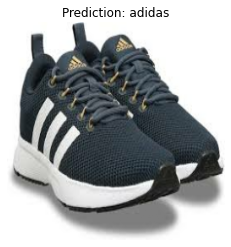

In [48]:
# Make a prediction using model_1
pred_and_plot(model=efficientnet_2_model, 
              filename="adidas_example_2.jpeg", 
              class_names=class_names)

# Conclusion

* Resnet : val_accuracy: 0.7456
* EfficientNet (version 1) : val_accuracy: 0.7982
* EfficientNet (version 2) : val_accuracy: 0.8246
* MobileNet : val_accuracy: 0.7368

EfficientNet (version 2) has the most validation accuracy and give better results than models without transfer learning From previous [notebook](https://github.com/adijams01/Sneakers_CNN/blob/main/Sneakers_CNN.ipynb)
